In [2]:
%load_ext autoreload
%autoreload 2

In [664]:
import pandas as pd
import data
from IPython.display import HTML
import myWidgets
import logisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

df = data.get_data()

Le but de ce projet est de construire un modèle de prédiction simple afin de me familiariser avec les concepts de base d'intelligence artificielle. 

Le projet va devoir prédire quels clients sont plus susceptibles d'acheter une assurance caravane en fonction des données provenant du CoIL 2000 Challenge. 

Les variables qui commence par M sont des variables qui donne de l'information sur la distribution de la variable dans le zipcode area du client. (0 = aucun, 9 = beaucoup). Ce n'est pas une zone!

In [ ]:
display(myWidgets.AllVarComparator(df.columns, df).get_widget())

In [533]:
# ordinale_vars, discrete_vars = data.get_var_by_types(df)
#corr = df.corr(numeric_only=True).loc[['CARAVAN']].sort_values(by='CARAVAN', axis=1, ascending=False).drop(columns='CARAVAN')
#corr_continuous = df[continuous_vars].corr().loc[['CARAVAN']].drop(columns=['CARAVAN'])
corr_discrete = df.corr(method='spearman').loc[['CARAVAN']].sort_values(by='CARAVAN', axis=1, ascending=False).drop(columns=['CARAVAN'])

#corr_combined = pd.concat([corr_continuous, corr_discrete], axis=1).sort_values(by='CARAVAN', axis=1, ascending=False)
corr_top = corr_discrete.unstack().sort_values(ascending=False) #2d a 1d (A,B)
corr_combined = corr_discrete.style.background_gradient(cmap='coolwarm', axis=None).format(precision=4)

display(HTML(corr_combined.to_html()))


,PPERSAUT,APERSAUT,APLEZIER,PPLEZIER,PBRAND,MINKGEM,PWAPART,MKOOPKLA,AWAPART,MHKOOP,MOPLHOOG,MAUT1,MINK4575,ABRAND,ABYSTAND,MRELGE,PBYSTAND,MINK7512,MSKA,MBERHOOG,MZPART,MBERMIDD,MOPLMIDD,MGEMOMV,MGODPR,PGEZONG,AGEZONG,MSKB1,PWAOREG,AWAOREG,AFIETS,MFWEKIND,PFIETS,MBERZELF,AZEILPL,PZEILPL,MGODRK,ALEVEN,AINBOED,PINBOED,PLEVEN,PAANHANG,AAANHANG,AMOTSCO,PMOTSCO,MAUT2,MFGEKIND,MSKB2,MINK123M,MGODOV,MGEMLEEF,AWABEDR,PWABEDR,MAANTHUI,MINK3045,PBESAUT,ABESAUT,APERSONG,PPERSONG,AVRAAUT,PVRAAUT,PWERKT,AWERKT,PTRACTOR,ATRACTOR,AWALAND,PWALAND,MRELSA,MGODGE,ABROM,PBROM,MSKC,MBERARBG,MFALLEEN,MZFONDS,MBERBOER,MBERARBO,MOSTYPE,MRELOV,MSKD,MOSHOOFD,MAUT0,MHHUUR,MINKM30,MOPLLAAG
CARAVAN,0.1637,0.1495,0.1064,0.1064,0.1006,0.1002,0.0953,0.0947,0.0900,0.0799,0.0782,0.0734,0.0699,0.0695,0.0682,0.0682,0.0681,0.0632,0.0600,0.0572,0.0554,0.0410,0.0399,0.0355,0.0348,0.0337,0.0335,0.0309,0.0303,0.0303,0.0289,0.0287,0.0287,0.0266,0.0262,0.0262,0.0196,0.0193,0.0191,0.0190,0.0186,0.0146,0.0145,0.0103,0.0099,0.0084,0.0075,0.0073,0.0072,0.0041,0.0039,0.0006,0.0006,-0.0011,-0.0063,-0.0069,-0.0070,-0.0085,-0.0085,-0.0099,-0.0099,-0.0152,-0.0152,-0.0165,-0.0167,-0.0213,-0.0213,-0.0274,-0.0414,-0.0452,-0.0452,-0.0485,-0.0508,-0.0517,-0.0562,-0.0565,-0.0572,-0.0580,-0.0581,-0.0611,-0.0615,-0.0775,-0.0806,-0.0815,-0.0907


Les 10 variables les plus correlated avec la cible sont :

In [534]:
data.top_index_and_values(10 ,corr_top)

Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799


In [651]:
ordinale_vars, discrete_vars = data.get_var_by_types(df)
discrete_vars.remove('CARAVAN')

X = df.drop('CARAVAN', axis=1) 
y = df['CARAVAN']  #targets
y_data = y.to_numpy()

X_final = X.to_numpy()

In [652]:
w,b = logisticRegression.logistic_regression(X_final, y_data)

Iteration 0: Cost = 0.6931471805599453
Iteration 100: Cost = 0.21419313203935106
Iteration 200: Cost = 0.20892953074285772
Iteration 300: Cost = 0.20642848265415942
Iteration 400: Cost = 0.20501209274303595
Iteration 500: Cost = 0.2041117658272042
Iteration 600: Cost = 0.20348519446137409
Iteration 700: Cost = 0.2030167349747296
Iteration 800: Cost = 0.202646458471174
Iteration 900: Cost = 0.20234109624974206


In [653]:
threshold = 0.1 #trop bas
y_prediction = logisticRegression.predict(X_final, w, b, threshold)
logisticRegression.print_model_stats(X_final, y_data, w, b, threshold)

Accuracy:  0.8173853289812747
[[4598  875]
 [ 188  160]]
AUC:  0.7497886699807415


Présentement le modèle est vraiment pas bon. Même avec un threshold de 0.1, il prédit seulement 160 qui ont besoin d'une assurance caravan en plus avec un threshold de seulement 0.1

In [654]:
print(np.bincount(y_data))

[5473  348]


La classe est imbalanced (5473 vs 348) avec un ratio d'environ 5473 / 348 = 15.7

Vu que la majoriter est "pas besoin d'assurance caravan", le modèle apprend probablement plutot a prédire: qui n'a pas besoin d'assurance caravan.

Donc je vais ajuster les weights pour que lorsque le modèle prédit incorrectement que quelqu'un a pas besoin d'assurance Caravan et qu'il ai tord, il sera pénaliser 15.7 fois plus. Comme ça, il va faire plus attention à eux que ceux qui n'ont pas besoin d'assurance caravan.

In [655]:
counts = np.bincount(y_data)
ratio = counts[0] / counts[1]

w,b = logisticRegression.logistic_regression(X_final, y_data, extra_weight=ratio)

Iteration 0: Cost = 0.6931471805599453
Iteration 100: Cost = 1.2029166631002273
Iteration 200: Cost = 1.0615666980427774
Iteration 300: Cost = 1.0187428201680466
Iteration 400: Cost = 0.9982490945470158
Iteration 500: Cost = 0.9836005930932303
Iteration 600: Cost = 0.9717426275776941
Iteration 700: Cost = 0.9617193100647379
Iteration 800: Cost = 0.9530322437413825
Iteration 900: Cost = 0.9453627342372549


Le cout augmente, donc peut-être le learning rate est trop grand. Je vais l'ajuster.

In [656]:
counts = np.bincount(y_data)
ratio = counts[0] / counts[1]

w,b = logisticRegression.logistic_regression(X_final, y_data, extra_weight=ratio, learning_rate=0.005)
w_old = w
b_old = b

Iteration 0: Cost = 0.6931471805599453
Iteration 100: Cost = 0.6184173475629691
Iteration 200: Cost = 0.6033539951719399
Iteration 300: Cost = 0.5974672832091306
Iteration 400: Cost = 0.594194235135878
Iteration 500: Cost = 0.5919956901236328
Iteration 600: Cost = 0.5903515765187757
Iteration 700: Cost = 0.5890360692409087
Iteration 800: Cost = 0.5879341665366692
Iteration 900: Cost = 0.5869809642446128


In [659]:
threshold = 0.1 #trop bas
logisticRegression.print_model_stats(X_final, y_data, w, b, threshold)

Accuracy:  0.08314722556261811
[[ 136 5337]
 [   0  348]]
AUC:  0.7617423359396494


C'est déja mieux, mais le threshold est trop bas. Je vais essayer 0.5

In [658]:
threshold = 0.5
logisticRegression.print_model_stats(X_final, y_data, w, b, threshold)

Accuracy:  0.6753135200137433
[[3679 1794]
 [  96  252]]
AUC:  0.7617423359396494


Beaucoup mieux, en plus avec un threshold de 0.5. Donc je croit, le modèle est asser précis maintenant. Je vais chercher le meilleur threshold.

In [660]:
y_proba = logisticRegression.predict_probas(X_final, w, b)
threshold, J = logisticRegression.youden_index_threshold(y_data, y_proba)

logisticRegression.print_model_stats(X_final, y_data, w, b, threshold)

Accuracy:  0.6613983851571895
[[3590 1883]
 [  88  260]]
AUC:  0.7617423359396494


Au faite non, il n'est pas asser précis. Il a 1883 False positive, donc il prédit 1883 personnes comme ayant besoin d'assurance caravan en faite que non, ils ont pas besoin. En plus, il manque pas mal de personne (88) qui ont actually besoin d'une assurance caravan.

In [604]:
data.top_index_and_values(10 ,corr_top)

Contribution car policies                          PPERSAUT   - 0.1637
Number of car policies                             APERSAUT   - 0.1495
Number of boat policies                            APLEZIER   - 0.1064
Contribution boat policies                         PPLEZIER   - 0.1064
Contribution fire policies                         PBRAND     - 0.1006
Average income                                     MINKGEM    - 0.1002
Contribution private third party insurance see L4  PWAPART    - 0.0953
Purchasing power class                             MKOOPKLA   - 0.0947
Number of private third party insurance 1 - 12     AWAPART    - 0.0900
Home owners                                        MHKOOP     - 0.0799


On voit que PPERSAUT & APERSAUT sont les variables qui corrèles le plus avec CARAVAN, ce qui fais du sens puisque pour utiliser une Caravan, il faut au minimum une voiture pour la remorquer. 
- Donc, je pourrais indiquer à mon modèle qui si la personne a aucune voiture, alors c'est un "pas besoin d'assurance caravan" ou tout simplement les retirer du dataset. (C'est mieux de pas retirer, car sinon il pourrait miss des patterns et mal classifiés des personnes plus tard)

De plus, APLEZIER, PPLEZIER et PBRAND nous dit que les personnes qui ont des caravans sont des personnes avec un bon income, c'est surtout des clients disposant d’un pouvoir d’achat élevé.
- Donc, s'il y a moyen, peut-etre d'indiquer au modèle de faire plus attention a eux?

Je peux ajouter des "interaction terms". Pour PPERSAUT et APERSAUT c'est parfait puisque l'effet de PPERSAUT sur la probabilité d'avoir besoin d'une assurance caravan, dépend de APERSAUT (ou en d'autre mots dépend du nombre de car policies).

In [ ]:
vars_to_test = [
    'PPERSAUT',   # Contribution car policies
    'APERSAUT',   # Number of car policies
    'APLEZIER',   # Number of boat policies
    'PPLEZIER',   # Contribution boat policies
    'PBRAND',     # Contribution fire policies
    'MINKGEM',    # Average income
    'PWAPART'     # Contribution private third party insurance see L4 
    'MKOOPKLA',   # Purchasing power class
    'AWAPART',    # Number of private third party insurance 1 - 12 
    'MHKOOP'      # Home owners
]
logisticRegression.interactions_terms_tester(X, y_data, w, b, vars_to_test=vars_to_test, learning_rate=0.005, ratio=ratio)

Interaction PPERSAUT_x_APERSAUT : AUC = 0.7625 (gain = +0.0008)
Interaction PPERSAUT_x_APLEZIER : AUC = 0.7655 (gain = +0.0038)
Interaction PPERSAUT_x_PPLEZIER : AUC = 0.7660 (gain = +0.0042)
Interaction PPERSAUT_x_PBRAND : AUC = 0.7679 (gain = +0.0062)
Interaction PPERSAUT_x_MINKGEM : AUC = 0.7616 (gain = -0.0001)
Interaction PPERSAUT_x_MKOOPKLA : AUC = 0.7621 (gain = +0.0004)
Interaction PPERSAUT_x_MHKOOP : AUC = 0.7621 (gain = +0.0004)
Interaction APERSAUT_x_APLEZIER : AUC = 0.7619 (gain = +0.0002)
Interaction APERSAUT_x_PPLEZIER : AUC = 0.7625 (gain = +0.0008)
Interaction APERSAUT_x_PBRAND : AUC = 0.7664 (gain = +0.0047)
Interaction APERSAUT_x_MINKGEM : AUC = 0.7619 (gain = +0.0002)
Interaction APERSAUT_x_MKOOPKLA : AUC = 0.7617 (gain = -0.0000)
Interaction APERSAUT_x_MHKOOP : AUC = 0.7620 (gain = +0.0002)
Interaction APLEZIER_x_PPLEZIER : AUC = 0.7635 (gain = +0.0017)
Interaction APLEZIER_x_PBRAND : AUC = 0.7623 (gain = +0.0006)
Interaction APLEZIER_x_MINKGEM : AUC = 0.7644 (gain 

Je vais commencer par ajouter tout les interactions qui ont au minimum +0.003 de gain. 
Donc, PPERSAUT_x_APLEZIER, PPERSAUT_x_PPLEZIER, PPERSAUT_x_PBRAND, APERSAUT_x_PBRAND, PPLEZIER_x_MINKGEM, PPLEZIER_x_MKOOPKLA, PPLEZIER_x_MHKOOP.

In [702]:
interactions_to_add_1 = [
    ("PPERSAUT", "APLEZIER"),
    ("PPERSAUT", "PPLEZIER"),
    ("PPERSAUT", "PBRAND"),
    ("APERSAUT", "PBRAND"),
    ("PPLEZIER", "MINKGEM"),
    ("PPLEZIER", "MKOOPKLA"),
    ("PPLEZIER", "MHKOOP"),
]
X_final = logisticRegression.add_interactions_terms(X, interactions_to_add_1)
w, b = logisticRegression.compare_auc_score(X.to_numpy(), y_data, w_old, b_old, X_final.to_numpy(), learning_rate=0.005, ratio=ratio)

New X : AUC = 0.7743 (gain = +0.0126)


In [699]:
logisticRegression.print_model_stats(X_final, y_data, w, b, threshold)

Accuracy:  0.6916337399072324
[[3782 1691]
 [ 104  244]]
AUC:  0.7742945515183208


Les intéractions ont ajoutés un gain d'environ 1.26%! Par contre, il faut que je vérifie que le gain n'est pas un surapprentissage.

In [700]:
X_test = data.get_test_data()
X_test_final = logisticRegression.add_interactions_terms(X_test, interactions_to_add_1)
y_test = data.get_test_targets()
y_test_data = y_test.to_numpy()

logisticRegression.print_model_stats(X_test, y_test_data, w_old, b_old, threshold)
print()
y_proba_test = logisticRegression.predict_probas(X_test_final, w, b)
threshold_test, J_test = logisticRegression.youden_index_threshold(y_test_data, y_proba_test)
logisticRegression.print_model_stats(X_test_final, y_test_data, w, b, threshold_test)

Accuracy:  0.6270015866057037
[[2495 1266]
 [  81  157]]
AUC:  0.7215048742177008

Accuracy:  0.6538778980816722
[[2617 1144]
 [  81  157]]
AUC:  0.7200536689017538


YES! L'ajout des interactions ont aider le modèle à être plus précis pour prédire les personnes qui ont pas besoin d'assurance caravan! Maintenant, je vais voir si ajouter les interactions de termes qui ont un gain d'au moins 0.002 marche bien. Donc : APLEZIER_x_MINKGEM, APLEZIER_x_MKOOPKLA, APLEZIER_x_MHKOOP

In [ ]:
interactions_to_add_2 = [
    ("APLEZIER", "MINKGEM"),
    ("APLEZIER", "MKOOPKLA"),
    ("APLEZIER", "MHKOOP")
]

w_from_interaction_1 = w
b_from_interaction_1 = b
X_final_from_interaction_1 = X_final

X_final = logisticRegression.add_interactions_terms(X_final_from_interaction_1, interactions_to_add_2)
w, b = logisticRegression.compare_auc_score(X_final_from_interaction_1.to_numpy(), y_data, w_from_interaction_1, b_from_interaction_1, X_final.to_numpy(), learning_rate=0.005, ratio=ratio)

New X : AUC = 0.7744 (gain = +0.0001)


In [696]:
logisticRegression.print_model_stats(X_final, y_data, w, b, threshold)

Accuracy:  0.6916337399072324
[[3782 1691]
 [ 104  244]]
AUC:  0.7744263374433741


seulement 0.01% de plus additionnel. Je crois pas sa vaut la peine de rajouter ces termes. Je retourne au aux variables précédentes.

In [ ]:
w = w_from_interaction_1
b = b_from_interaction_1
X_final = X_final_from_interaction_1

make_scorer(f1_score, response_method='predict')


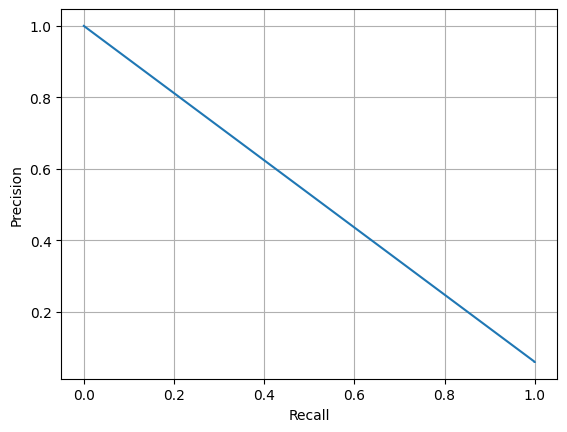

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_data, y_prediction) #better for imbalanced datasets
#fpr, tpr, thresholds = roc_curve(y_test_data, y_prediction)
f1 = f1_score(y_test_data, y_prediction)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

In [ ]:
data.compare_models()

version: 1
Premiere version car 
0.5902765847792476
[[3162 2311]
 [  74  274]]

version: 2
Ajout du traitement des variables discrètes en variables binaires car Certaine variables sont discrètes
0.8739048273492527
[[4944  529]
 [ 205  143]]

version: 3
Traitement de tout les variables en variables binaires car Tout les variables sont discrètes
0.8861020443222813
[[5030  443]
 [ 220  128]]



In [ ]:
data.save_model_state(w,b,threshold,accuracy,conf_matrix,3)